In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


In [23]:
# config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
import torch
from torch import nn
import torch.nn.functional as F

# -------------------------
# Basic Residual Block
# -------------------------
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, 
                               padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, 
                               padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)
        
        self.downsample = downsample
        if downsample is not None:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

# -------------------------
# Helper: Stack multiple residual blocks
# -------------------------
class ResidualStack(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks=2):
        super(ResidualStack, self).__init__()
        layers = []
        for i in range(num_blocks):
            if i == 0 and in_channels != out_channels:
                layers.append(ResidualBlock(in_channels, out_channels, stride=1, downsample=True))
            else:
                layers.append(ResidualBlock(out_channels, out_channels, stride=1, downsample=None))
        self.stack = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.stack(x)

# -------------------------
# Encoder / Decoder blocks
# -------------------------
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_res_blocks=2):
        super(EncoderBlock, self).__init__()
        self.down = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, 
                              padding=1, bias=False)
        self.bn   = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.res  = ResidualStack(out_channels, out_channels, num_res_blocks)
    
    def forward(self, x):
        x = self.down(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.res(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_res_blocks=2):
        """
        in_channels here includes the channels from skip connection concatenation.
        """
        super(DecoderBlock, self).__init__()
        self.up   = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, 
                                       stride=2, padding=1, bias=False)
        self.bn   = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.res  = ResidualStack(out_channels, out_channels, num_blocks=num_res_blocks)
    
    def forward(self, x, skip=None):
        # Concatenate skip connection before upsampling if available
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.up(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.res(x)
        return x

# -------------------------
# Complex VAE (U-Net style)
# -------------------------
class ComplexConvVAE(nn.Module):
    def __init__(self, in_channels=3, latent_dim=256):
        super(ComplexConvVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder blocks
        self.enc1 = EncoderBlock(in_channels, 64,  num_res_blocks=2)   # 64x64 -> 32x32
        self.enc2 = EncoderBlock(64, 128, num_res_blocks=2)            # 32x32 -> 16x16
        self.enc3 = EncoderBlock(128, 256, num_res_blocks=2)           # 16x16 -> 8x8
        self.enc4 = EncoderBlock(256, 512, num_res_blocks=2)           # 8x8 -> 4x4
        
        self.flatten_dim = 512 * 4 * 4
        self.fc_mu     = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

        # Decoder blocks
        self.fc_decode = nn.Linear(latent_dim, self.flatten_dim)
        
        self.dec4 = DecoderBlock(512, 256, num_res_blocks=2)   # No skip for first decoder
        self.dec3 = DecoderBlock(256 + 256, 128, num_res_blocks=2)  # Concatenate skip from enc3
        self.dec2 = DecoderBlock(128 + 128, 64, num_res_blocks=2)   # Concatenate skip from enc2
        self.dec1 = DecoderBlock(64 + 64, 64, num_res_blocks=2)     # Concatenate skip from enc1
        
        self.out_conv = nn.Conv2d(64, in_channels, kernel_size=3, stride=1, padding=1)
        self.out_act  = nn.Sigmoid()

    def encode(self, x):
        x1 = self.enc1(x)  # [B, 64, 32, 32]
        x2 = self.enc2(x1) # [B, 128, 16, 16]
        x3 = self.enc3(x2) # [B, 256, 8, 8]
        x4 = self.enc4(x3) # [B, 512, 4, 4]

        x4_flat = x4.view(x4.size(0), -1)
        mu = self.fc_mu(x4_flat)
        logvar = self.fc_logvar(x4_flat)
        return mu, logvar, [x1, x2, x3, x4]

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, skips=None):
        if skips is None:
            skips = [None]*4
        x1, x2, x3, x4 = skips

        x = self.fc_decode(z)
        x = x.view(x.size(0), 512, 4, 4)

        x = self.dec4(x)            # [B, 256, 8, 8]
        x = self.dec3(x, skip=x3)   # [B, 128, 16, 16]
        x = self.dec2(x, skip=x2)   # [B, 64, 32, 32]
        x = self.dec1(x, skip=x1)   # [B, 64, 64, 64]
        
        x = self.out_conv(x)
        x = self.out_act(x)
        return x

    def forward(self, x):
        mu, logvar, skips = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, skips)
        return recon, mu, logvar

    @torch.no_grad()
    def sample(self, num_samples, device=None):
        if device is None:
            device = next(self.parameters()).device
        z = torch.randn(num_samples, self.latent_dim).to(device)
        samples = self.decode(z)
        return samples

# Quick test
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ComplexConvVAE(in_channels=3, latent_dim=256).to(device)
    # Use input size 64x64 to match the architecture's assumptions
    dummy_input = torch.randn(2, 3, 64, 64).to(device)  
    recon, mu, logvar = model(dummy_input)
    print("Reconstructed shape:", recon.shape)  
    print("mu shape:", mu.shape)                
    print("logvar shape:", logvar.shape)        


Reconstructed shape: torch.Size([2, 3, 64, 64])
mu shape: torch.Size([2, 256])
logvar shape: torch.Size([2, 256])


In [25]:
def vae_loss(recon, x, mu, logvar):
    """
    recon: Reconstructed images from the decoder.
    x: Original images.
    mu, logvar: Mean and log-variance from the encoder.
    """
    recon_loss = F.binary_cross_entropy(recon, x, reduction='sum') / x.size(0)
    
    # KL Divergence: D_KL(Q(z|x) || P(z))
    # = 0.5 * sum( exp(logvar) + mu^2 - 1 - logvar )
    # We'll divide by batch size as well for an average.
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    
    return recon_loss + kl_loss, recon_loss, kl_loss


In [26]:
def train_vae(model, train_loader, num_epochs=10, lr=1e-3, device="cuda"):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    # Lists to store metrics for each epoch
    epoch_losses = []
    epoch_recon_losses = []
    epoch_kl_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        total_recon_loss = 0.0
        total_kl_loss = 0.0

        for batch in train_loader:
            images, _ = batch  # Unpack images and ignore labels
            images = images.to(device)

            optimizer.zero_grad()
            recon, mu, logvar = model(images)
            loss, recon_loss, kl_loss = vae_loss(recon, images, mu, logvar)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)
            total_recon_loss += recon_loss.item() * images.size(0)
            total_kl_loss += kl_loss.item() * images.size(0)

        dataset_size = len(train_loader.dataset)
        avg_loss = total_loss / dataset_size
        avg_recon = total_recon_loss / dataset_size
        avg_kl = total_kl_loss / dataset_size
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Loss: {avg_loss:.4f}, "
              f"Recon: {avg_recon:.4f}, "
              f"KL: {avg_kl:.4f}")

        # Store metrics for plotting
        epoch_losses.append(avg_loss)
        epoch_recon_losses.append(avg_recon)
        epoch_kl_losses.append(avg_kl)

    return epoch_losses, epoch_recon_losses, epoch_kl_losses

In [27]:
def test_vae(model, test_loader, device="cuda"):
    model.eval()
    total_loss = 0.0
    total_recon_loss = 0.0
    total_kl_loss = 0.0

    with torch.no_grad():
        for batch in test_loader:
            images, _ = batch  # Unpack images and ignore labels
            images = images.to(device)
            recon, mu, logvar = model(images)
            loss, recon_loss, kl_loss = vae_loss(recon, images, mu, logvar)
            total_loss += loss.item() * images.size(0)
            total_recon_loss += recon_loss.item() * images.size(0)
            total_kl_loss += kl_loss.item() * images.size(0)

    dataset_size = len(test_loader.dataset)
    print(f"Test Loss: {total_loss/dataset_size:.4f}, "
          f"Recon: {total_recon_loss/dataset_size:.4f}, "
          f"KL: {total_kl_loss/dataset_size:.4f}")


In [43]:
import matplotlib.pyplot as plt
import torch

def plot_24_originals_and_reconstructions(model, data_loader, device):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)
    model.eval()
    
    # Retrieve one batch and select the first 24 images
    data_iter = iter(data_loader)
    images, _ = next(data_iter)
    images = images[:24].to(device)  # select first 24 images

    # Compute reconstructions for these images
    with torch.no_grad():
        recon, _, _ = model(images)

    # Move images and reconstructions to CPU for plotting
    images = images.cpu()
    recon = recon.cpu()

    # Define grid layout: 6 rows x 8 columns
    rows, cols = 6, 8
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))

    # Loop over the 24 images to place originals and reconstructions in pairs of rows
    for i in range(24):
        pair_index = i // 8         # 0 for first 8, 1 for next 8, 2 for last 8
        col = i % 8                 # column within the row
        row_original = pair_index * 2      # even row for originals
        row_recon = row_original + 1       # odd row for reconstructions

        # Display original image
        axes[row_original, col].imshow(images[i].permute(1, 2, 0).squeeze(), cmap='gray')
        axes[row_original, col].axis('off')

        # Display corresponding reconstruction
        axes[row_recon, col].imshow(recon[i].permute(1, 2, 0).squeeze(), cmap='gray')
        axes[row_recon, col].axis('off')

    # Optionally add titles for clarity on first column of each pair
    axes[0,0].set_title("Originals (1-8)", fontsize=10)
    axes[1,0].set_title("Reconstructions (1-8)", fontsize=10)
    axes[2,0].set_title("Originals (9-16)", fontsize=10)
    axes[3,0].set_title("Reconstructions (9-16)", fontsize=10)
    axes[4,0].set_title("Originals (17-24)", fontsize=10)
    axes[5,0].set_title("Reconstructions (17-24)", fontsize=10)

    plt.tight_layout()
    plt.show()


In [29]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define your device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data paths and parameters
TRAIN_PATH = "./tiny-imagenet-200/train"
TEST_PATH = "./tiny-imagenet-200/test"
BATCH_SIZE = 256

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Ensure images are 64x64
    transforms.ToTensor()
])

# num_epochs=100
# print(num_epochs)

# train_data = datasets.ImageFolder(TRAIN_PATH, transform=transform)
# train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=5)

# test_data = datasets.ImageFolder(TEST_PATH, transform=transform)
# test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=5)

# # Initialize VAE
# vae = ComplexConvVAE(latent_dim=128)
# vae.to(device)

# # Train VAE
# train_vae(vae, train_loader, num_epochs, lr=1e-4, device=device)

# # Save the trained VAE model's state_dict
# MODEL_SAVE_PATH = "vae_state_dict.pth"
# torch.save(vae.state_dict(), MODEL_SAVE_PATH)
# print(f"Model's state_dict saved to {MODEL_SAVE_PATH}")

# # Test VAE
# test_vae(vae, test_loader, device=device)


In [30]:
from sklearn.manifold import TSNE
import numpy as np

def visualize_latent_space(model, data_loader, device, num_batches=1):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)
    model.eval()
    latents = []
    labels_list = []

    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader):
            images = images.to(device)
            _, mu, _ = model(images)
            latents.append(mu.cpu())
            labels_list.append(labels)
            if (i + 1) == num_batches:
                break

    latents = torch.cat(latents, dim=0).numpy()
    labels_list = torch.cat(labels_list, dim=0).numpy()

    if latents.shape[1] > 2:
        from sklearn.manifold import TSNE
        tsne = TSNE(n_components=2, random_state=0)
        latent_2d = tsne.fit_transform(latents)
    else:
        latent_2d = latents

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels_list, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label="Label")
    plt.title('Latent Space Visualization')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()


# Instantiate your model (with appropriate parameters if needed)
model = ComplexConvVAE(latent_dim=128)  # Use the correct arguments for your model's constructor

# Move the model to the desired device
model.to(device)

ComplexConvVAE(
  (enc1): EncoderBlock(
    (down): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (res): ResidualStack(
      (stack): Sequential(
        (0): ResidualBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): ResidualBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (r

In [31]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D projection

def visualize_latent_space_3d_tsne(model, data_loader, device='cuda', num_batches=1):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)
    model.eval()
    latents = []
    labels_list = []

    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader):
            images = images.to(device)
            _, mu, _ = model(images)
            latents.append(mu.cpu())
            labels_list.append(labels)
            if (i + 1) == num_batches:
                break

    # Concatenate all the batches
    latents = torch.cat(latents, dim=0).numpy()   # Shape: (num_samples, latent_dim)
    labels_list = torch.cat(labels_list, dim=0).numpy()

    # Use t-SNE to reduce to 3 dimensions
    tsne = TSNE(n_components=3, random_state=42)
    latent_3d = tsne.fit_transform(latents)

    # Plot in 3D
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2],
                         c=labels_list, cmap='viridis', alpha=0.7)

    ax.set_title('3D t-SNE Latent Space')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Dimension 3')
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.6)
    cbar.set_label("Label")
    plt.show()

model.to(device)

ComplexConvVAE(
  (enc1): EncoderBlock(
    (down): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (res): ResidualStack(
      (stack): Sequential(
        (0): ResidualBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): ResidualBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (r

In [ ]:
def reproduce_hw4():
    import torch
    from torch import nn, optim
    from torchvision import datasets, transforms
    from torch.utils.data import DataLoader
    # Make sure to import your VAE model and visualization function:
    # from your_model_file import ComplexConvVAE
    # from your_visualization_file import plot_24_originals_and_reconstructions

    # ========================
    # 1. Device Configuration
    # ========================
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # =========================
    # 2. Data Paths and Params
    # =========================
    # For testing/visualization we only need the test dataset.
    TEST_PATH = "./tiny-imagenet-200/test"  # Adjust path as needed
    BATCH_SIZE = 256
    MODEL_SAVE_PATH = "model_weights.pkl"

    # =====================
    # 3. Data Transformations
    # =====================
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Ensure images are 64x64
        transforms.ToTensor()
    ])

    # ===================
    # 4. Load Test Dataset
    # ===================
    try:
        # Assuming test data is organized in subfolders similar to train.
        test_data = datasets.ImageFolder(TEST_PATH, transform=transform)
        test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=5)
        print("Test dataset loaded successfully.")
    except Exception as e:
        print(f"Error loading test dataset: {e}")
        return

    # ======================
    # 5. Initialize VAE
    # ======================
    vae = ComplexConvVAE(latent_dim=128).to(device)
    print("VAE model initialized.")

    # ===============================
    # 6. Load the Pre-trained Model
    # ===============================
    import pickle

    try:
        # Load the state dict using pickle.load instead of torch.load
        with open(MODEL_SAVE_PATH, 'rb') as f:
            state_dict = pickle.load(f)
        vae.load_state_dict(state_dict)
        print(f"Loaded model's state_dict from {MODEL_SAVE_PATH}")
    except FileNotFoundError:
        print(f"Error: No saved model found at {MODEL_SAVE_PATH}. Please ensure the file exists in the current folder.")
        return
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    # ==========================
    # 7. Define Testing Function
    # ==========================
    def test_vae(model, dataloader, device):
        model.eval()
        test_loss = 0
        criterion = nn.BCELoss(reduction='sum')
        with torch.no_grad():
            for data, _ in dataloader:
                data = data.to(device)
                reconstructed, mu, logvar = model(data)
                BCE = criterion(reconstructed, data)
                KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                loss = BCE + KLD
                test_loss += loss.item()
        average_loss = test_loss / len(dataloader.dataset)
        print(f"====> Test set loss: {average_loss:.4f}")

    # =====================
    # 8. Test the VAE
    # =====================
    print("Starting testing...")
    test_vae(vae, test_loader, device)

    # ===========================
    # 9. Visualize Results
    # ===========================
    plot_24_originals_and_reconstructions(vae, test_loader, device=device)
    # visualize_latent_space(vae, train_loader, device=device, num_batches=100)
    # visualize_latent_space_3d_tsne(model, train_loader, device=device, num_batches=20)


Using device: cpu
Test dataset loaded successfully.
VAE model initialized.
Loaded model's state_dict from vae_state_dict.pkl
Starting testing...
====> Test set loss: 6197.5092


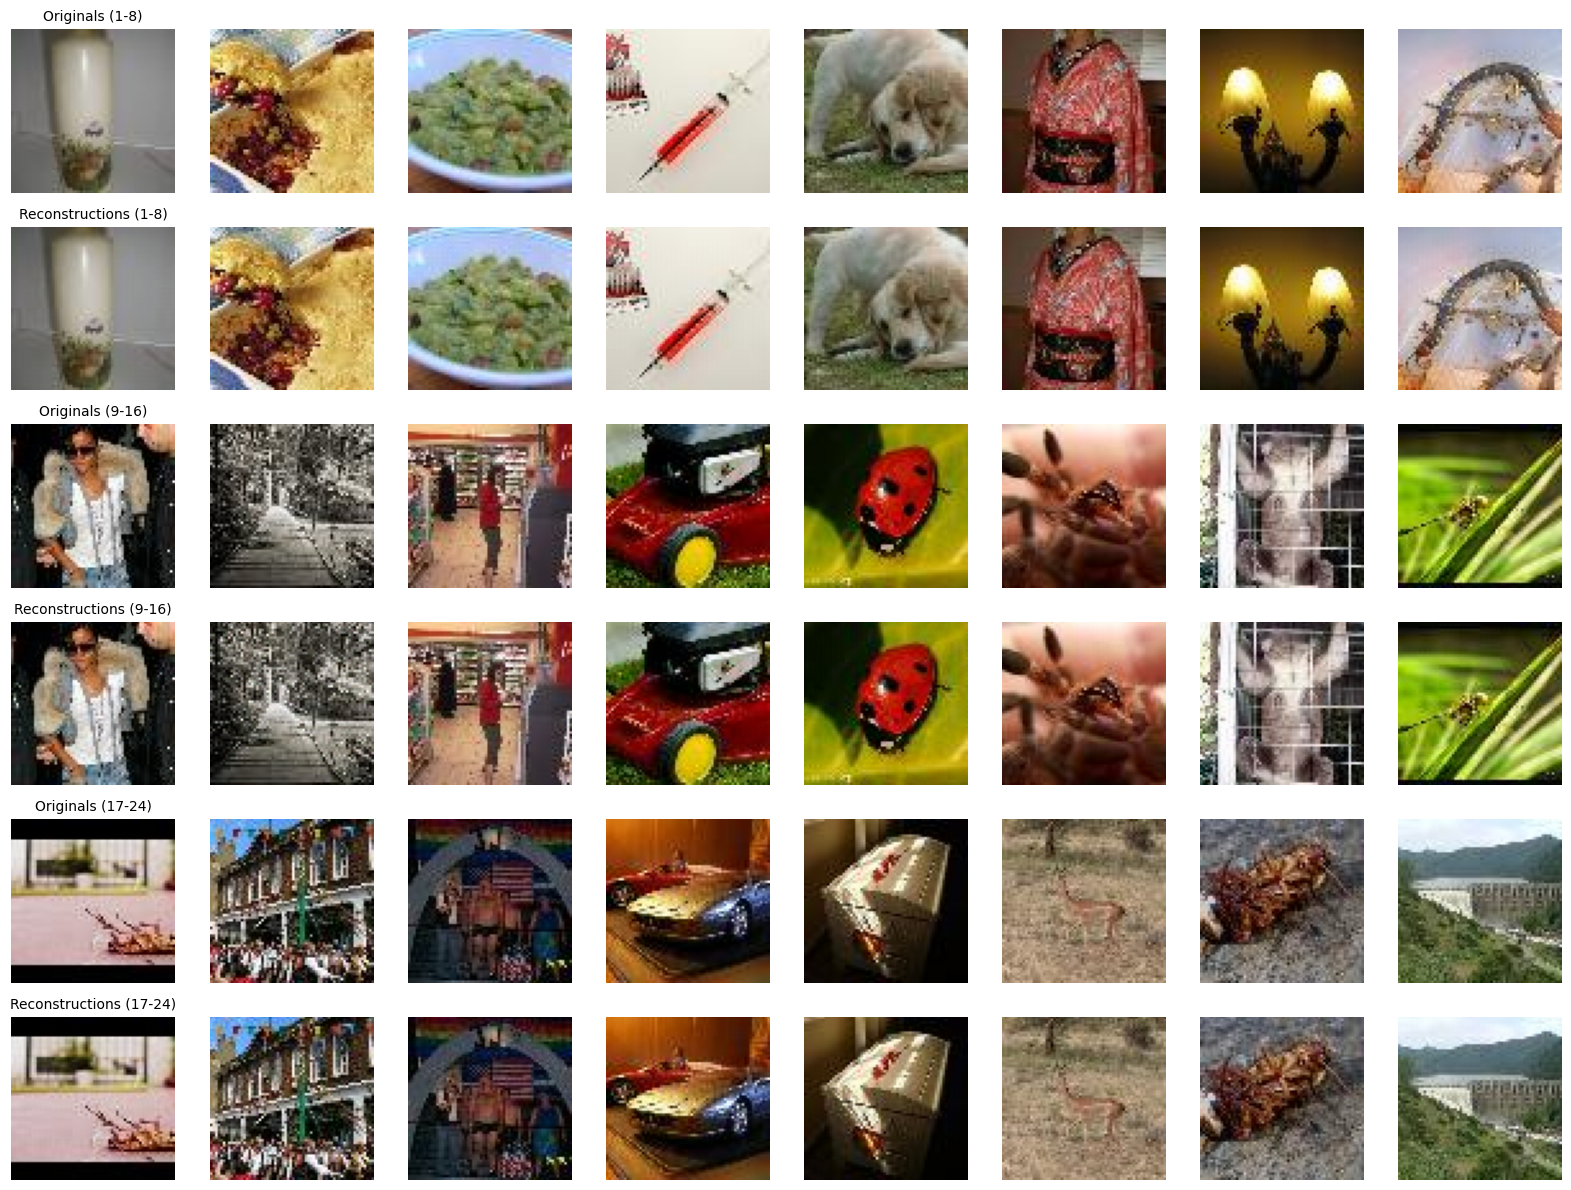

In [49]:
if __name__ == "__main__":
    reproduce_hw4()